# EDA

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
tracks_with_genres = pd.read_csv('../data/ml_analysis/tracks_with_genres.csv')

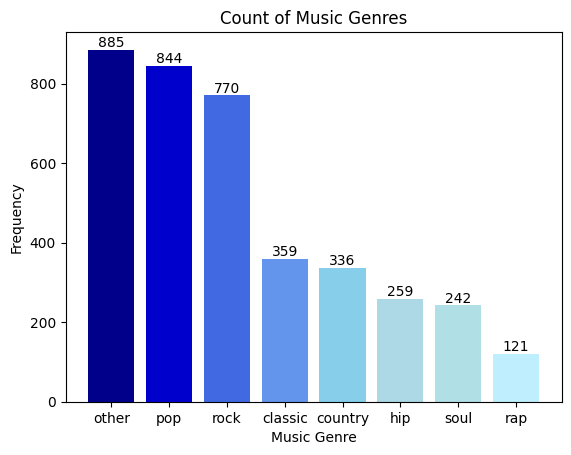

In [44]:
labels = tracks_with_genres['genre'].value_counts()
colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB', '#ADD8E6', '#B0E0E6', '#BFEFFF']
plt.bar(labels.index, height=labels, color=colors)
plt.xlabel('Music Genre')
plt.ylabel('Frequency')
plt.title('Count of Music Genres')
for i, freq in enumerate(labels):
    plt.text(i, freq, str(freq), ha='center', va='bottom')
plt.savefig('report/count_of_music_genres.png', dpi=300)

# Machine Learning

In [97]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [98]:
train_data = np.load('train_data.npy')
train_label = np.load('train_label.npy')
test_data = np.load('test_data.npy')
test_label = np.load('test_label.npy')

In [99]:
feature_names = ['year', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'valence', 'popularity', 'duration_min', 'duration_sec']

# Decision Tree

In [100]:
from sklearn.tree import DecisionTreeClassifier

In [101]:
dt_default = DecisionTreeClassifier(random_state=200)
dt_default.fit(train_data, train_label)
train_pred = dt_default.predict(train_data)
accuracy_score(train_label, train_pred)

0.970520799213888

In [102]:
test_pred = dt_default.predict(test_data)
accuracy_score(test_label, test_pred)

0.3564875491480996

In [93]:
feats_with_imps = list(zip(feature_names, dt_default.feature_importances_))
feats_with_imps.sort(key=lambda x : x[1])

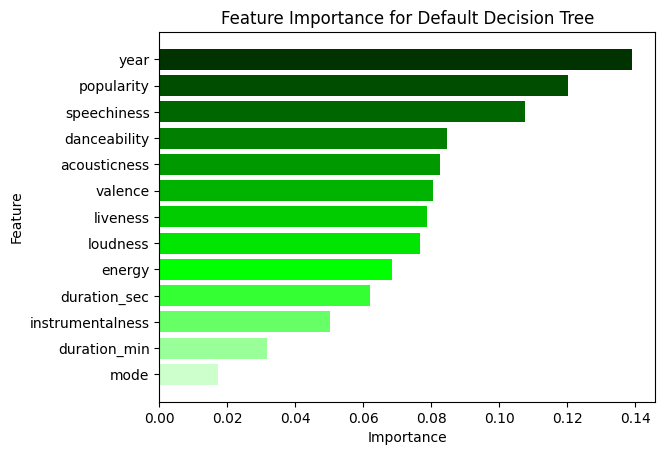

In [94]:
feats, imps = zip(*feats_with_imps)
colors = ['#ccffcc', '#99ff99', '#66ff66', '#33ff33', '#00ff00', '#00e600', '#00cc00', '#00b300', '#009900', '#007f00', '#006600', '#004d00', '#003300']
plt.barh(feats, imps, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Default Decision Tree')
plt.show()

In [6]:
parameters = {'max_depth': np.linspace(10, 50, 5).astype(int),
              'min_samples_split': np.linspace(2, 14, 4).astype(int),
              'ccp_alpha': 10 ** np.linspace(-3, -2, 10)}
dt = GridSearchCV(DecisionTreeClassifier(random_state=350), parameters)
dt.fit(train_data, train_label)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=350),
             param_grid={'ccp_alpha': array([0.001     , 0.00129155, 0.0016681 , 0.00215443, 0.00278256,
       0.00359381, 0.00464159, 0.00599484, 0.00774264, 0.01      ]),
                         'max_depth': array([10, 20, 30, 40, 50]),
                         'min_samples_split': array([ 2,  6, 10, 14])})

In [17]:
train_pred = dt.predict(train_data)
accuracy_score(train_label, train_pred)

0.4867343596462496

In [18]:
test_pred = dt.predict(test_data)
accuracy_score(test_label, test_pred)

0.44036697247706424

# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
rf_default = RandomForestClassifier(random_state=1000)
rf_default.fit(train_data, train_label)
train_pred = rf_default.predict(train_data)
accuracy_score(train_label, train_pred)

0.970520799213888

In [74]:
test_pred = rf_default.predict(test_data)
accuracy_score(test_label, test_pred)

0.5045871559633027

In [95]:
feats_with_imps = list(zip(feature_names, rf_default.feature_importances_))
feats_with_imps.sort(key=lambda x : x[1])
feats, imps = zip(*feats_with_imps)

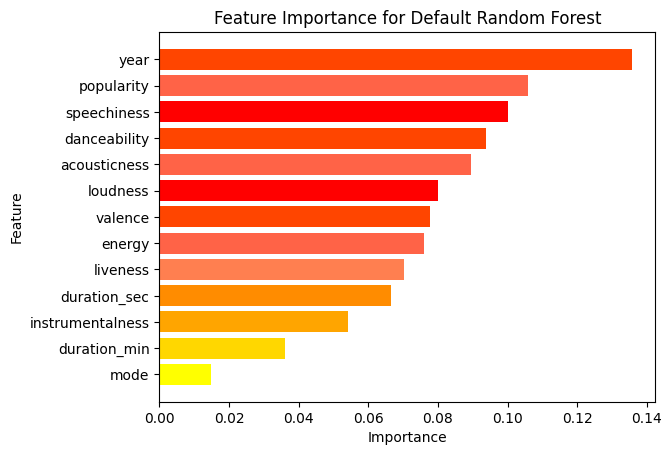

In [96]:
colors = ['#FFFF00', '#FFD700', '#FFA500', '#FF8C00', '#FF7F50', '#FF6347', '#FF4500', '#FF0000', '#FF6347', '#FF4500', '#FF0000', '#FF6347', '#FF4500']
plt.barh(feats, imps, color=colors)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importance for Default Random Forest')
plt.show()

In [30]:
parameters = {'max_depth': np.linspace(10, 50, 5).astype(int),
              'min_samples_split': np.linspace(2, 14, 4).astype(int),
              'ccp_alpha': 10 ** np.linspace(-3, -2, 10)}
rf = GridSearchCV(RandomForestClassifier(random_state=355), parameters)
rf.fit(train_data, train_label)

GridSearchCV(estimator=RandomForestClassifier(random_state=355),
             param_grid={'ccp_alpha': array([0.001     , 0.00129155, 0.0016681 , 0.00215443, 0.00278256,
       0.00359381, 0.00464159, 0.00599484, 0.00774264, 0.01      ]),
                         'max_depth': array([10, 20, 30, 40, 50]),
                         'min_samples_split': array([ 2,  6, 10, 14])})

In [31]:
train_pred = rf.predict(train_data)
accuracy_score(train_label, train_pred)

0.804454634785457

In [32]:
pred = rf.predict(test_data)
accuracy_score(test_label, pred)

0.47313237221494103

# Gradient Boosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
gbm_default = GradientBoostingClassifier(random_state=999)
gbm_default.fit(train_data, train_label)
train_pred = gbm_default.predict(train_data)
accuracy_score(train_label, train_pred)

0.7392728463806092

In [22]:
test_pred = gbm_default.predict(test_data)
accuracy_score(test_label, test_pred)

0.4875491480996068

In [109]:
parameters = {'learning_rate': 10 ** np.linspace(-3, -2, 10)}
gbm = GridSearchCV(GradientBoostingClassifier(random_state=1000), parameters)
gbm.fit(train_data, train_label)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=1000),
             param_grid={'learning_rate': array([0.001     , 0.00129155, 0.0016681 , 0.00215443, 0.00278256,
       0.00359381, 0.00464159, 0.00599484, 0.00774264, 0.01      ])})

In [110]:
train_pred = gbm.predict(train_data)
accuracy_score(train_label, train_pred)

0.508679986898133

In [111]:
test_pred = gbm.predict(test_data)
accuracy_score(test_label, test_pred)

0.436435124508519

# XGBoost

In [112]:
import xgboost as xgb

In [113]:
dtrain = xgb.DMatrix(data=train_data, label=train_label)
dtest = xgb.DMatrix(data=test_data)

In [115]:
parameters = {'objective': 'multi:softmax', 'num_class': 8, 'seed': 100}
bst_default = xgb.train(parameters, dtrain)
train_pred = bst_default.predict(dtrain)
accuracy_score(train_label, train_pred)

0.7497543399934491

In [116]:
test_pred = bst_default.predict(dtest)
accuracy_score(test_label, test_pred)

0.48230668414154654

In [118]:
parameters = {'objective': 'multi:softmax',
              'num_class': 8,
              'seed': 300,
              'eta': 0.001}
bst = xgb.train(parameters, dtrain)

In [119]:
train_pred = bst.predict(dtrain)
accuracy_score(train_label, train_pred)

0.5964624959056666

In [120]:
test_pred = bst.predict(dtest)
accuracy_score(test_label, test_pred)

0.4429882044560944

# Gaussian Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

In [18]:
nb = GaussianNB()
nb.fit(train_data, train_label)
train_pred = nb.predict(train_data)
accuracy_score(train_label, train_pred)

0.3576809695381592

In [19]:
test_pred = nb.predict(test_data)
accuracy_score(test_label, test_pred)

0.3722149410222805